In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import adjusted_mutual_info_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score, normalized_mutual_info_score
import umap.umap_ as umap
from scipy.spatial.distance import pdist

%matplotlib inline

def nmi(y, labels):
    nmi_ = normalized_mutual_info_score(y, labels, average_method='geometric')
    return nmi_

def distance_pair(arr, oth_arr, type='euclidean', p=2):
    k = oth_arr.shape[0]
    n = arr.shape[0]
    diff_matrix = np.zeros((k, n))
    if type=='euclidean':
        for i in range(k):
            diff = (arr - oth_arr[i])
            diff_prod = diff.dot(diff.T)
            diff_matrix[i] = np.sqrt(diff_prod[np.diag_indices(n)])
    if type=='manhattan':
        for i in range(k):
            diff = abs(arr - oth_arr[i])
            diff_matrix[i] = np.sum(diff, axis=1)
    if type=='lp':
        for i in range(k):
            diff = (arr - oth_arr[i])
            diff = diff**p
            diff_prod = diff.sum()
            diff_prod = diff.dot(diff.T)
            diff_matrix[i] = np.sqrt(diff_prod[np.diag_indices(n)])
            
    return diff_matrix.T

def kmeans(X, k, random_state=123):
    np.random.seed(random_state)
    n = X.shape[0]
    centroids = X[np.random.randint(0, n, k), :]
    num_iter = 300
    labels = np.argmin(distance_pair(X, centroids), axis=1)
    for iter in range(num_iter):
        for i in range(k):
            centroids[i] = X[np.where(labels==i)[0],:].mean(axis=0)
        new_labels = np.argmin(distance_pair(X, centroids), axis=1)
        if np.array_equal(labels, new_labels):
            return labels
        labels = new_labels
    return labels

def plot_data_2d(X_2d, y, xlabel, ylabel, title):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

def plot_data_3d(X_3d, y, xlabel, ylabel, zlabel, title):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylabel(zlabel)
    ax.set_title(title)

def draw_class_cluster_subplots(X_2d, classes, clusters, xlabel, ylabel, title_1, title_2):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    ax1.scatter(X_2d[:, 0], X_2d[:, 1], c=classes)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_title(title_1)
    ax2.scatter(X_2d[:, 0], X_2d[:, 1], c=clusters)
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(ylabel)
    ax2.set_title(title_2)

df = pd.read_csv('msdata.csv')
X = df.iloc[:,2:].to_numpy()
y = df['class'].to_numpy()

In [3]:
# The following code performs all necessary steps to produce an NMI score of 0.97
pca = KernelPCA(n_components=140, kernel='cosine')
X_red_pca = pca.fit_transform(X)
spect = SpectralClustering(n_clusters=3, gamma=1, n_init=100, affinity='poly', degree=10)
labels_spect = spect.fit_predict(X_red_pca)
print('Highest achieved NMI score:', nmi(y, labels_spect))

Highest achieved NMI score: 0.9748507760700306


In [4]:
print('shape', df.shape)
print('nulls', df.isnull().sum().sum())
print('min', df.iloc[:,2:].min().min())
print('max', df.iloc[:,2:].max().max())
duplicateRowsDF = df[df.iloc[:, 2:].duplicated()]
display(duplicateRowsDF)

shape (694, 5002)
nulls 0
min 0.0
max 26.3404


,id,class,f1,f2,f3,f4,f5,f6,f7,f8,...,f4991,f4992,f4993,f4994,f4995,f4996,f4997,f4998,f4999,f5000


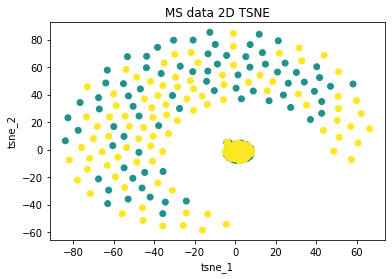

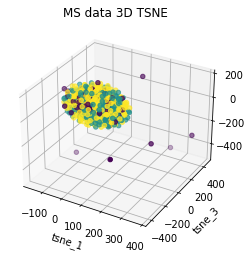

In [5]:
# Visualization using t-SNE (2D and 3D)
X_tsne_2d = TSNE(n_components=2, perplexity=100).fit_transform(X)
X_tsne_3d = TSNE(n_components=3).fit_transform(X)
plot_data_2d(X_tsne_2d, y, 'tsne_1', 'tsne_2', 'MS data 2D TSNE')
plot_data_3d(X_tsne_3d, y, 'tsne_1', 'tsne_2', 'tsne_3', 'MS data 3D TSNE')

In [6]:
# Comparison of clustering methods using NMI and internal validity indices
# No dimensionality reductions
ks = range(2,10)

silh_sklearn = []
ch_sklearn = []
db_sklearn = []
nmi_sklearn = []
nmi_custom = []

silh_sklearn_spectral = []
ch_sklearn_spectral = []
db_sklearn_spectral = []
nmi_sklearn_spectral = []
nmi_custom_spectral = []

silh_sklearn_agglo = []
ch_sklearn_agglo = []
db_sklearn_agglo = []
nmi_sklearn_agglo = []
nmi_custom_agglo = []

silh_sklearn_db = []
ch_sklearn_db = []
db_sklearn_db = []
nmi_sklearn_db = []
nmi_custom_db = []

for k in ks:
    model = KMeans(n_clusters=k)
    labels = model.fit_predict(X)
    silh_sklearn.append(silhouette_score(X, labels))
    ch_sklearn.append(calinski_harabasz_score(X, labels))
    db_sklearn.append(davies_bouldin_score(X, labels))
    nmi_sklearn.append(adjusted_mutual_info_score(y, labels))
    nmi_custom.append(nmi(y, labels))

for k in ks:
    model = SpectralClustering(n_clusters=k, gamma=1, n_init=100, affinity='poly', degree=15)
    labels = model.fit_predict(X)
    silh_sklearn_spectral.append(silhouette_score(X, labels))
    ch_sklearn_spectral.append(calinski_harabasz_score(X, labels))
    db_sklearn_spectral.append(davies_bouldin_score(X, labels))
    nmi_sklearn_spectral.append(adjusted_mutual_info_score(y, labels))
    nmi_custom_spectral.append(nmi(y, labels))

for k in ks:
    model = AgglomerativeClustering(n_clusters=k, linkage='single', affinity='cosine')
    labels = model.fit_predict(X)
    silh_sklearn_agglo.append(silhouette_score(X, labels))
    ch_sklearn_agglo.append(calinski_harabasz_score(X, labels))
    db_sklearn_agglo.append(davies_bouldin_score(X, labels))
    nmi_sklearn_agglo.append(adjusted_mutual_info_score(y, labels))
    nmi_custom_agglo.append(nmi(y, labels))


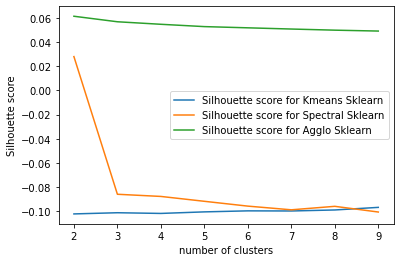

In [7]:
plt.plot(ks, silh_sklearn, label='Silhouette score for Kmeans Sklearn')
plt.plot(ks, silh_sklearn_spectral, label='Silhouette score for Spectral Sklearn')
plt.plot(ks, silh_sklearn_agglo, label='Silhouette score for Agglo Sklearn')
plt.xlabel('number of clusters')
plt.ylabel('Silhouette score')
plt.legend()

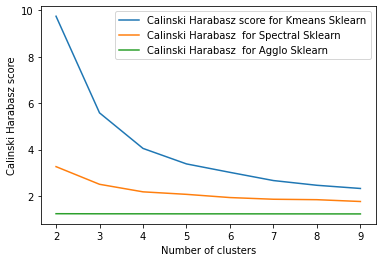

In [8]:
plt.plot(ks, ch_sklearn , label='Calinski Harabasz score for Kmeans Sklearn')
plt.plot(ks, ch_sklearn_spectral, label='Calinski Harabasz  for Spectral Sklearn')
plt.plot(ks, ch_sklearn_agglo, label='Calinski Harabasz  for Agglo Sklearn')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski Harabasz score')
plt.legend()

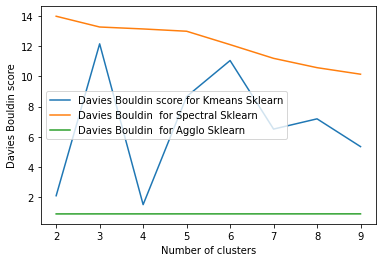

In [9]:
plt.plot(ks, db_sklearn , label='Davies Bouldin score for Kmeans Sklearn')
plt.plot(ks, db_sklearn_spectral, label='Davies Bouldin  for Spectral Sklearn')
plt.plot(ks, db_sklearn_agglo, label='Davies Bouldin  for Agglo Sklearn')

plt.xlabel('Number of clusters')
plt.ylabel('Davies Bouldin score')

plt.legend()

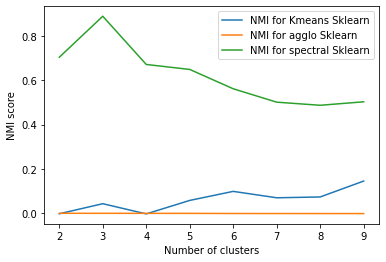

In [10]:
plt.plot(ks, nmi_sklearn , label='NMI for Kmeans Sklearn')
plt.plot(ks, nmi_sklearn_agglo, label='NMI for agglo Sklearn')
plt.plot(ks, nmi_sklearn_spectral, label='NMI for spectral Sklearn')

plt.xlabel('Number of clusters')
plt.ylabel('NMI score')

plt.legend()

Text(0, 0.5, 'Cumulative explained variance')

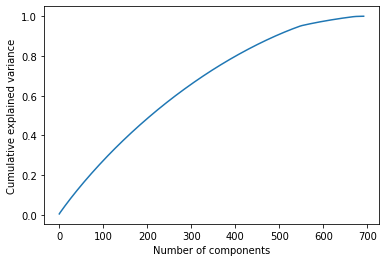

In [11]:
kpca = KernelPCA(kernel='cosine').fit_transform(X)
explained_variance = np.var(kpca, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [20]:
# INITIALIZE RESULTS DICT WITH HIGHEST ACHIEVED SCORE
results_dict = {'affinity': ['poly'], 'dim_reduction': ['None'], 'nmi':[0.89]}

In [21]:
# PCA - COMPARE DIFFERENT KERNELS
for i, kernel in enumerate(('linear', 'rbf', 'cosine', 'sigmoid', 'poly')):
    pca = KernelPCA(n_components=50, kernel=kernel)
    X_red_pca = pca.fit_transform(X)
    spect = SpectralClustering(n_clusters=3, gamma=1, n_init=100, affinity='poly', degree=10)
    labels_spect = spect.fit_predict(X_red_pca)

    results_dict['affinity'].append('poly')
    results_dict['nmi'].append(nmi(y, labels_spect))
    results_dict['dim_reduction'].append('PCA (components=50, kernel={})'.format(kernel))
    print(kernel, nmi(y, labels_spect))

# PCA - COMPARE DIFFERENT COMPONENT COUNTS
for i in range(10, 200, 10):
    pca = KernelPCA(n_components=i, kernel='cosine')
    X_red_pca = pca.fit_transform(X)
    spect = SpectralClustering(n_clusters=3, gamma=1, n_init=100, affinity='poly', degree=10)
    labels_spect = spect.fit_predict(X_red_pca)
    
    if (i == 10 or i == 80 or i == 140 or i == 190):
        results_dict['affinity'].append('poly')
        results_dict['nmi'].append(nmi(y, labels_spect))
        results_dict['dim_reduction'].append('PCA (components={}, kernel=cosine)'.format(i))
        print(i, nmi(y, labels_spect))



linear 0.5070696378293287
rbf 0.020594416032303463
cosine 0.9435065545021399
sigmoid 0.006975966398296877
poly 0.029327271320254082
10 0.9259840350845627
80 0.9435065545021397
140 0.9748507760700308
190 0.9748507760700306


In [22]:
# SPECTRAL CLUSTERING - COMPARE AFFINITIES
for i, affinity in enumerate(('nearest_neighbors', 'rbf', 'poly', 'polynomial', 'laplacian', 'sigmoid')):
    pca = KernelPCA(n_components=140, kernel='cosine')
    X_red_pca = pca.fit_transform(X)
    spect = SpectralClustering(n_clusters=3, gamma=1, n_init=100, affinity=affinity)
    labels_spect = spect.fit_predict(X_red_pca)

    results_dict['affinity'].append(affinity)
    results_dict['nmi'].append(nmi(y, labels_spect))
    results_dict['dim_reduction'].append('PCA (components=140, kernel=cosine)')
    print(kernel, nmi(y, labels_spect))

poly 0.5687663005360153
poly 0.9435065545021399
poly 0.9748507760700308
poly 0.9748507760700308
poly 0.844379580949275
poly 0.9748507760700308


In [36]:
# ATTEMPT AT USING TSNE AND UMAP FOR DIMENSIONALITY REDUCTION
# The following methods did not produce satisfactory scores and are thus ignored. 
# Multiple parameters were altered, not seen here.

# TSNE
reducer_tsne = TSNE(n_components=2, perplexity=30) 
X_red_tsne = reducer_tsne.fit_transform(X)
spect = SpectralClustering(n_clusters=3, gamma=1, n_init=100, affinity='poly', degree=10)
labels_spect = spect.fit_predict(X_red_tsne)
results_dict['affinity'].append('poly')
results_dict['dim_reduction'].append('TSNE (components=2, perplexity=30)')
results_dict['nmi'].append(nmi(y, labels_spect))
print(i, nmi(y, labels_spect))

# UMAP
reducer_umap = umap.UMAP(
    n_neighbors=2,
    min_dist=0.0,
    n_components=10,
    random_state=42) 
X_red_umap = reducer_umap.fit_transform(X)
spect = SpectralClustering(n_clusters=3, gamma=1, n_init=100, affinity='poly', degree=10)
labels_spect = spect.fit_predict(X_red_umap)
results_dict['affinity'].append('poly')
results_dict['dim_reduction'].append('UMAP (neighbors=2, components=10)')
results_dict['nmi'].append(nmi(y, labels_spect))
print(i, nmi(y, labels_spect))

3 0.05732752499553381
2 0.0023220131288669297
12 0.0014458899090505149
22 0.0014458899090505149
32 0.0005659620232584384
42 0.002725034494155197
52 0.00045092876059976846
62 0.0013168921767631445
72 0.0014603685540141708
82 0.0038305053433667297
92 0.0018388702815220676


In [37]:
rdf = pd.DataFrame(results_dict)
rdf.style.set_caption("Spectral clustering")
rdf.sort_values('nmi', ascending=False, ignore_index=True)

,affinity,dim_reduction,nmi
0,poly,"PCA (components=140, kernel=cosine)",0.974851
1,sigmoid,"PCA (components=140, kernel=cosine)",0.974851
2,polynomial,"PCA (components=140, kernel=cosine)",0.974851
3,poly,"PCA (components=140, kernel=cosine)",0.974851
4,poly,"PCA (components=190, kernel=cosine)",0.974851
5,poly,"PCA (components=50, kernel=cosine)",0.943507
6,rbf,"PCA (components=140, kernel=cosine)",0.943507
7,poly,"PCA (components=80, kernel=cosine)",0.943507
8,poly,"PCA (components=10, kernel=cosine)",0.925984
9,poly,None,0.890000


In [35]:
# Agglomerative
results_dict_agglo = {'affinity': [], 'dim_reduction': [], 'nmi':[]}

In [24]:
# ATTEMPT AT USING AGGLOMERATIVE CLUSTERING
# PCA, TSNE AND UMAP used for dimensionality reduction
# Multiple paramterers were altered and compared

# PCA
pca = KernelPCA(n_components=140, kernel='cosine')
X_red_pca = pca.fit_transform(X)
    
# TSNE
reducer_tsne = TSNE(n_components=2, perplexity=30) 
X_red_tsne = reducer_tsne.fit_transform(X_red_pca)

# UMAP
reducer_umap = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=10,
    random_state=42) 
X_red_umap = reducer_umap.fit_transform(X_red_pca)


for i, linkage in enumerate(('ward', 'single', 'complete', 'average')):
    agglo = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    labels_agglo = agglo.fit_predict(X)
    labels_agglo_pca = agglo.fit_predict(X_red_pca)
    labels_agglo_tsne = agglo.fit_predict(X_red_tsne)
    labels_agglo_umap = agglo.fit_predict(X_red_umap)
    
    results_dict['affinity'].append('poly')
    results_dict['dim_reduction'].append('UMAP (neighbors=2, components=10)')
    results_dict['nmi'].append(nmi(y, labels_spect))
    print(linkage, nmi(y, labels_agglo))




ward 0.2840866472160896
single 0.018971829084704715
complete 0.19109328400372913
average 0.018971829084704715


In [72]:
reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42) 
X_red_umap = reducer.fit_transform(X)
kmeans = KMeans(n_clusters=3)
# db = DBSCAN(eps=0.1, min_samples=30).fit_predict(X)
labels_umap = kmeans.fit_predict(X_red_umap)
display(nmi(y, labels_umap))
display(adjusted_mutual_info_score(y, labels_umap, average_method="geometric"))

0.00044710239108737814

-0.002759187394462854

Distances to overcome curse of dimensionality
    - LP with small p
    - Cosine similarity
    - match based similarity
    
Mahalanobis distance to take distribution into account
Isomap 

KMeans Cosine similarity

Text(0, 0.5, 'frequency')

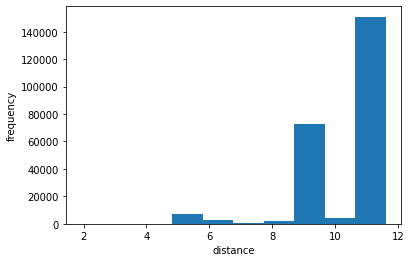

In [461]:
plt.hist(pairwise_dist)
plt.xlabel('distance')
plt.ylabel('frequency')

Study entropy

In [218]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [254]:
X_train, X_test, y_train, y_test = train_test_split(X_min_max, y, test_size=0.1)

In [255]:
df['class'].value_counts(normalize=True)

3    0.446686
2    0.373199
1    0.180115
Name: class, dtype: float64

In [228]:
lr = LogisticRegression(multi_class='multinomial')

In [256]:
scores = []
for i in range(5000):
    lr.fit(X_train[:,i].reshape((-1, 1)), y_train)
    scores.append(f1_score(y_test, lr.predict(X_test[:,i].reshape((-1,1))), average='macro'))

0.4615384615384616

0.16117216117216115

(694, 1538)
0.7506632174155985


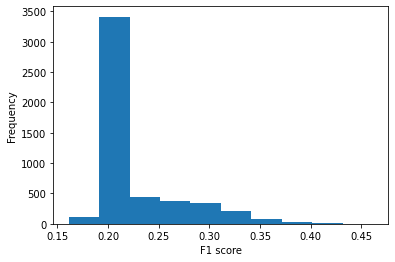

In [253]:
display(np.max(scores))
display(np.min(scores))
plt.hist(scores)
plt.xlabel('F1 score')
plt.ylabel('Frequency')

X_model_select = X[:,np.argwhere((np.array(scores)<0.19) | (np.array(scores)>0.22)).flatten()]
print(X_model_select.shape)
pca = KernelPCA(n_components=50, kernel='cosine')
X_red_pca = pca.fit_transform(X)
spect = SpectralClustering(n_clusters=3, gamma=1, n_init=100, affinity='poly', degree=10)
labels_spect = spect.fit_predict(X_model_select)
print(nmi(y, labels_spect))

DBSCAN

In [33]:
db = DBSCAN(eps=1, min_samples=1).fit(X_red_pca)
labels = db.fit_predict(X_red_pca)
nmi(y, labels)

0.25